In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# Data Import

This part prepares extra data for my main dataset with physician info. 
This one adds data on how many drugs each physician prescribes (prescribed in 2018).
Note that this data is aggregated and can be added only after the main dataset is aggregated,so that each row represents a unique physician

In [ ]:
#getting prescriptions data from CMS
df = pd.read_csv(r'D:/PartD_Prescriber_PUF_NPI_18.txt',sep='\t',header=(0))
print(df.head())
#selecting only the columns we need - how many drugs prescribed and total cost
df = df [['npi','total_claim_count','total_drug_cost']]
print(df.head())
#summarizing data by provider
df = df.groupby('npi').sum()
print(df.shape)
print(df.head())
# saving dataset to push it my SQL server
df.to_csv('D:/Data Repo/Mila/2018_prescriptions_summary_data.csv')

This part creates the main dataset with physician info for each impression in 2020 by connecting to the SQL server
and running the query below. To calculate the target variable, the amount of money each prescriber 'earned' for the company, this data set needs to be aggregated by npi.

In [12]:
#TO DO BEFORE SUBMISSION - REMOVE CREDENTIALS
engine = create_engine(
    "CREDENTIALS REMOVED",
)

QUERY = """
SELECT
m.npi AS 'npi', 
r.first_name AS first_name,
r.last_name AS last_name,
IFNULL(r.gender, 'N/A') AS gender,
IFNULL(r. address1, 'N/A') AS address,
IFNULL(r.city, 'N/A') AS city,
r.state AS state,
LEFT(r.zipcode,5) AS zipcode,
r. sole_proprietor_ind AS sole_proprietor,
r.medicare_ind, 
medicaid_ind,
t.name AS 'specialty',
total_procedures,
distinct_procedures,
institution,
derived_specialty_list,
event_ts,
adiolineitemid,
li.costperdrop,
dropsize,
costperdrop/dropsize as impression_cost,
r.cbm_id,
CASE client_key				
	WHEN 'AMAEXPAND'			
		THEN 'AMA'		
	WHEN 'RDBDMD'			
		THEN 'RDB'		
	WHEN 'NEUROCCF'			
		THEN 'NEURO'		
	WHEN 'NEURODMD'			
		THEN 'NEURO'		
	WHEN 'CCRADIODMD'			
		THEN 'CCRADIO'		
	WHEN 'CCENDODMD'			
		THEN 'CCENDO'		
	WHEN 'DENTALRD'			
		THEN 'DENTAL'		
	WHEN 'DENTALDMD'			
		THEN 'DENTAL'		
	WHEN 'DENTALHEALTHLINK'			
		THEN 'DENTAL'		
	ELSE client_key			
	END AS 'publicationid',
clients.is_pii_enabled,
h.city AS hospital_city, 
h.state AS hospital_state,
LEFT(h.zipcode,5) as hospital_zip,
h.latitude AS hospital_latitude,
h.longitude AS hospital_longitude,
h.hospital_size AS hospital_size,
h.system_member AS hospital_system_membership

FROM research.ad_io_line_item_drop_event e 
		INNER JOIN research.adiolineitemdrop d ON (e.ad_io_line_item_drop_id = d.adiolineitemdropid)
		INNER JOIN research.adiolineitem li USING(adiolineitemid)
		INNER JOIN
		research.recipients r ON (e.recipient_id = r.cbm_id)
		INNER JOIN
		research.clients USING(client_id)
		INNER JOIN
		research.recipientmatch m ON (r.cbm_id = m.cbm_id AND total_score >= 65)
        LEFT JOIN  research.npitaxonomy USING (npi)
		LEFT JOIN  research.taxonomy t ON (npitaxonomy.taxonomy_code = t.code)
        LEFT JOIN temp_darcy.hospital_affiliation USING(npi)
        LEFT JOIN temp_darcy.hospital h USING(ccn)
        LEFT JOIN (SELECT npi, count(procedure_name) AS total_procedures, count(distinct procedure_name) AS distinct_procedures
					FROM temp_darcy.procedures
					GROUP BY npi) as procedures USING (npi)

	WHERE runstatus = 'Y'
	AND date(event_ts) BETWEEN '2020-01-01' AND '2020-03-01'
    AND dropsize > 0
    AND costperdrop > 0
    LIMIT 200000
"""

with engine.connect() as con:
    rs = con.execute(QUERY)
    df_main = pd.DataFrame(rs.fetchall()) #fetchall() lists all results
    df_main.columns = rs.keys()
    con.close()
print(df_main.head())
print(df_main.shape)

          npi          first_name last_name gender address       city state  \
0  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
1  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
2  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
3  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   
4  1316146061  Florello Sven-Erik  Quianzon    N/A     N/A  SKOWHEGAN    ME   

  zipcode sole_proprietor medicare_ind  ...   cbm_id publicationid  \
0   04976               N            N  ...  5094890           CCF   
1   04976               N            N  ...  5094890           CCF   
2   04976               N            N  ...  5094890           CCF   
3   04976               N            N  ...  5094890           CCF   
4   04976               N            N  ...  5094890           CCF   

   is_pii_enabled  hospital_city hospital_state hospital_zip  \
0         b'\x01'      Skowhegan        

In [16]:
#saving the dataframe so we don't have to fetch it every time
df_main.to_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_main.csv', index=False)

# Combining Datasets

In [76]:
df_main = pd.read_csv(r'C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_main.csv')

In [77]:
print(df_main.head())
print (df_main.shape)

          npi first_name last_name gender address       city state zipcode  \
0  1518226661       Ryan  Sychterz      M     NaN        BOW    NH   03304   
1  1518226661       Ryan  Sychterz      M     NaN        BOW    NH   03304   
2  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   
3  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   
4  1942444237      Sarah      Finn    NaN     NaN  NEWFIELDS    NH   03856   

  sole_proprietor medicare_ind  ...   cbm_id publicationid  is_pii_enabled  \
0               N            N  ...  5918490         SEMPA         b'\x01'   
1               N            N  ...  5918490         SEMPA         b'\x01'   
2               N            N  ...  5753963           AMA         b'\x00'   
3               N            N  ...  5753963           AMA         b'\x00'   
4               N            N  ...  5753963           AMA         b'\x00'   

   hospital_city hospital_state hospital_zip hospital_latitude

In [78]:
#from the main dataframe summarizing how much money each doctor generated by summing all impressions and 
#impression costs for each unique npi
df_money = df_main.groupby('npi')['impression_cost'].sum().reset_index(name='money_generated')
df_impressions = df_main.groupby('npi')['event_ts'].count().reset_index(name='impressions_count')
df_money = pd.merge(df_money,df_impressions)
print(df_money.shape)
print(df_money.head())

(13914, 3)
          npi  money_generated  impressions_count
0  1003000415         0.072093                  3
1  1003011610         0.129176                 32
2  1003012436         0.003150                  1
3  1003012634         2.835712                 20
4  1003015785         0.022761                  1


In [79]:
#data = pd.merge(df_money, df_main, how='left')
data = pd.concat([df_money, df_main], axis=1, join="inner")
print(data.shape)
print(data.head())

(13914, 34)
          npi  money_generated  impressions_count         npi first_name  \
0  1003000415         0.072093                  3  1518226661       Ryan   
1  1003011610         0.129176                 32  1518226661       Ryan   
2  1003012436         0.003150                  1  1942444237      Sarah   
3  1003012634         2.835712                 20  1942444237      Sarah   
4  1003015785         0.022761                  1  1942444237      Sarah   

  last_name gender address       city state  ...   cbm_id publicationid  \
0  Sychterz      M     NaN        BOW    NH  ...  5918490         SEMPA   
1  Sychterz      M     NaN        BOW    NH  ...  5918490         SEMPA   
2      Finn    NaN     NaN  NEWFIELDS    NH  ...  5753963           AMA   
3      Finn    NaN     NaN  NEWFIELDS    NH  ...  5753963           AMA   
4      Finn    NaN     NaN  NEWFIELDS    NH  ...  5753963           AMA   

  is_pii_enabled hospital_city hospital_state  hospital_zip  \
0        b'\x01' 

In [80]:
#Next step: merge prescriptions data
prescriptions = pd.read_csv('D:/Data Repo/Mila/2018_prescriptions_summary_data.csv')
print(prescriptions.head())
prescriptions.shape

data = pd.concat([data, prescriptions], axis=1, join="inner")
print(data.head())
data.shape


          npi  total_claim_count  total_drug_cost
0  1003000126                492         27744.26
1  1003000142               1818        124220.94
2  1003000167                 77           502.88
3  1003000282                100          5132.53
4  1003000407               2766        118165.29
          npi  money_generated  impressions_count         npi first_name  \
0  1003000415         0.072093                  3  1518226661       Ryan   
1  1003011610         0.129176                 32  1518226661       Ryan   
2  1003012436         0.003150                  1  1942444237      Sarah   
3  1003012634         2.835712                 20  1942444237      Sarah   
4  1003015785         0.022761                  1  1942444237      Sarah   

  last_name gender address       city state  ... hospital_city hospital_state  \
0  Sychterz      M     NaN        BOW    NH  ...       Concord             NH   
1  Sychterz      M     NaN        BOW    NH  ...       Concord             NH   


(13914, 37)

# Data Cleansing

In [81]:
#getting rid of the columns that won't be useful:
data.columns

data = data[['npi', 'money_generated', 'impressions_count','gender', 'city', 'state', 'zipcode',
       'sole_proprietor','specialty',
       'total_procedures', 'distinct_procedures', 'institution',
       'derived_specialty_list', 'event_ts','impression_cost', 'cbm_id', 'publicationid',
       'is_pii_enabled', 'hospital_city', 'hospital_state', 'hospital_zip',
       'hospital_latitude', 'hospital_longitude', 'hospital_size',
       'hospital_system_membership', 'total_claim_count',
       'total_drug_cost']]

data.shape

(13914, 29)

In [82]:
#removing personally identifiable information
data.drop(['npi'], axis=1, inplace=True)

In [83]:
#resetting index
data.reset_index()
data.describe()

,money_generated,impressions_count,total_procedures,distinct_procedures,impression_cost,cbm_id,hospital_zip,hospital_latitude,hospital_longitude,total_claim_count,total_drug_cost
count,13914.000000,13914.000000,10253.000000,10253.000000,13914.000000,1.391400e+04,9214.000000,9214.000000,9214.000000,13914.00000,1.391400e+04
mean,0.801886,14.374012,66.848435,24.285672,0.066485,5.331762e+06,52041.199262,38.276259,-92.659593,1273.46694,1.421869e+05
std,6.159175,74.776296,65.111084,20.412275,0.061104,1.251608e+06,30712.346946,5.653228,17.031135,2943.21429,3.587448e+05
min,0.001534,1.000000,1.000000,1.000000,0.001887,1.537567e+06,918.000000,18.419300,-158.026000,11.00000,1.763000e+01
25%,0.016601,2.000000,22.000000,9.000000,0.004713,4.940876e+06,27262.000000,34.087500,-104.997000,54.00000,1.532315e+03
50%,0.073613,4.000000,46.000000,20.000000,0.051780,5.849519e+06,49307.000000,39.744800,-87.400800,206.00000,1.024302e+04
75%,0.366000,10.000000,111.000000,42.000000,0.113588,6.138721e+06,80524.000000,41.395800,-79.946800,1028.00000,1.107496e+05
max,392.581244,4392.000000,679.000000,164.000000,1.092555,7.083745e+06,99508.000000,61.210400,-66.064500,49994.00000,8.042474e+06


The max for impression_cost and count looks unrealistic. It's likely that the opens generated by a robot.Might need to look at the overall distribution.Hospital zip is likely an object, but it's treated like an integer. Data type needs to be changed.

In [85]:
data.dtypes

money_generated               float64
impressions_count               int64
gender                         object
city                           object
state                          object
zipcode                        object
sole_proprietor                object
specialty                      object
total_procedures              float64
distinct_procedures           float64
institution                    object
derived_specialty_list         object
event_ts                       object
impression_cost               float64
cbm_id                          int64
publicationid                  object
is_pii_enabled                 object
hospital_city                  object
hospital_state                 object
hospital_zip                  float64
hospital_latitude             float64
hospital_longitude            float64
hospital_size                  object
hospital_system_membership     object
total_claim_count               int64
total_drug_cost               float64
dtype: objec

In [86]:
data['hospital_zip'] = data['hospital_zip'].astype(str)
data.dtypes

money_generated               float64
impressions_count               int64
gender                         object
city                           object
state                          object
zipcode                        object
sole_proprietor                object
specialty                      object
total_procedures              float64
distinct_procedures           float64
institution                    object
derived_specialty_list         object
event_ts                       object
impression_cost               float64
cbm_id                          int64
publicationid                  object
is_pii_enabled                 object
hospital_city                  object
hospital_state                 object
hospital_zip                   object
hospital_latitude             float64
hospital_longitude            float64
hospital_size                  object
hospital_system_membership     object
total_claim_count               int64
total_drug_cost               float64
dtype: objec

In [87]:
#exploring NULL values
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13914 entries, 0 to 13913
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   money_generated             13914 non-null  float64
 1   impressions_count           13914 non-null  int64  
 2   gender                      2041 non-null   object 
 3   city                        13327 non-null  object 
 4   state                       13313 non-null  object 
 5   zipcode                     13342 non-null  object 
 6   sole_proprietor             13869 non-null  object 
 7   specialty                   13914 non-null  object 
 8   total_procedures            10253 non-null  float64
 9   distinct_procedures         10253 non-null  float64
 10  institution                 1277 non-null   object 
 11  derived_specialty_list      13014 non-null  object 
 12  event_ts                    13914 non-null  object 
 13  impression_cost             139

From the above, it looks like most records are missing gender info as well as institution. We'll drop these columns.
In addition hospital membembership is missing half of the values. Let's see if this an empty cell means the value is truly missing

In [88]:
data['hospital_system_membership'].unique()

array([nan, 'Y'], dtype=object)

It turns out that NaN in this case means that the hospital is not a member of a larger hospital system, so there is no need to get rid of this column. However, 'Y' must be recoded later.

In [89]:
#dropping columns with a lot of missing values
data.drop(['gender', 'institution'], axis=1,inplace=True)
data.shape

(13914, 24)

Let's explore the distributions of our continious variables and see if we have outliers

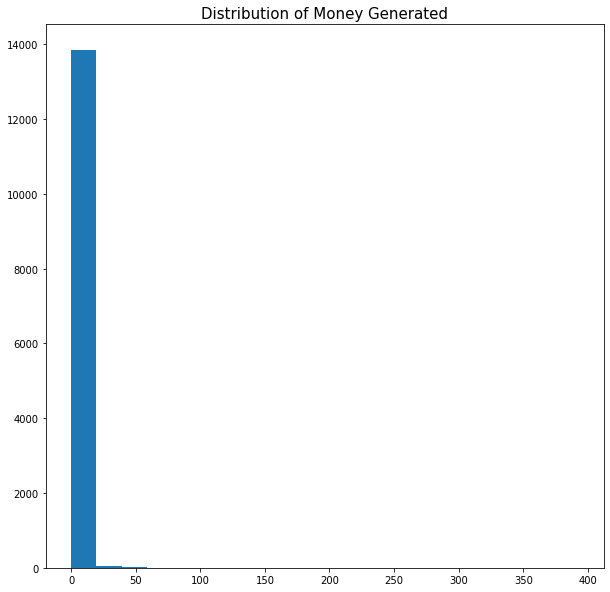

In [90]:
plt.figure(figsize=(10,10))
plt.title('Distribution of Money Generated',fontsize=15)
plt.hist(data['money_generated'], bins=20)
plt.show()

In [91]:
print(data['money_generated'].min())
print(data['money_generated'].max())
print(data['money_generated'].mean())
print(data['money_generated'].std())
data['money_generated'].quantile(q=0.95)

0.001534
392.5812440000003
0.8018862332183392
6.159175125090951


2.538085899999997

Looks like the target variable's statistics is distorted by an extreme outlier: max is 392 dollars, the mean is 80 dollars, whereas 90% of the sample contributed no more than 2.54 dollars. The max of 392 dollarscorresponds to 4,392 impressions. It's possible that this data point was generated by a bot or some software, not by human. We'll get rid of this outlier by limiting our dataset to only those falling within the 95th percentile. 

In [92]:
data = data.loc[(data['money_generated'] <=2.54)]

In [93]:
print(data.shape)

(13220, 24)


Thus, we have filtered out about 700 practitioners. Let's explore the distribution again.

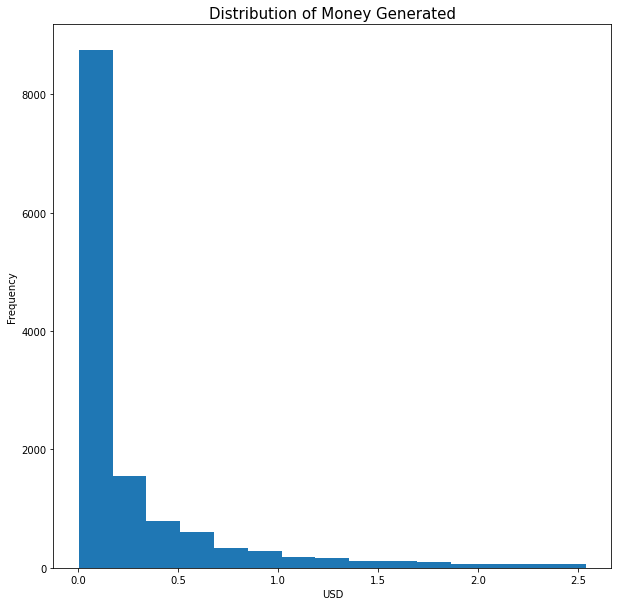

0.001534
2.5394520000000003
0.2577195036308629
0.4377620284117259


In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Distribution of Money Generated',fontsize=15)
plt.xlabel('USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.hist(data['money_generated'], bins=15)
plt.show()
print(data['money_generated'].min())
print(data['money_generated'].max())
print(data['money_generated'].mean())
print(data['money_generated'].std())

The data is still highly skewed to the right. One commonly applied method to normalize this type of distribution is to log-transform the original values. Let's create an additional column where we transform the values of 'money_generated' into their natural logarithmic values with a base of 10. 

In [101]:
import numpy as np
data['money_generated_log'] = np.log10(data['money_generated'])

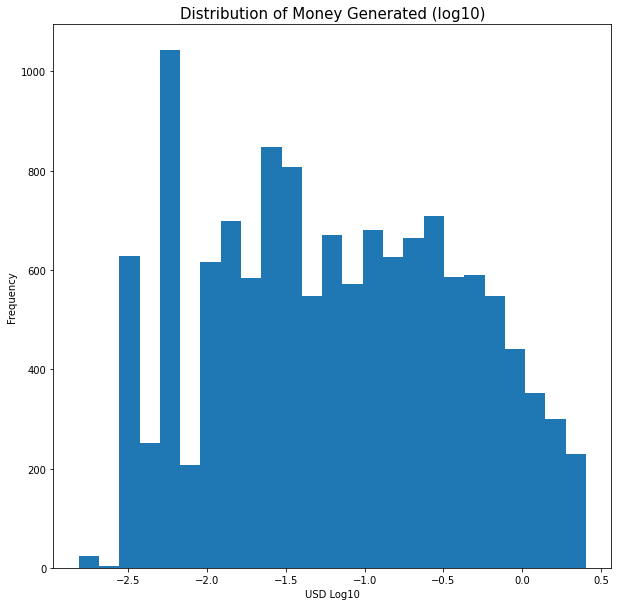

In [106]:
plt.figure(figsize=(10,10))
plt.xlabel('USD Log10',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Money Generated (log10)',fontsize=15)
plt.hist(data['money_generated_log'], bins=25)
plt.show()

While the resulting distribution is still far from looking normal, despite multimodality it now looks a lot better. Let's continue exploring the remaining variables.

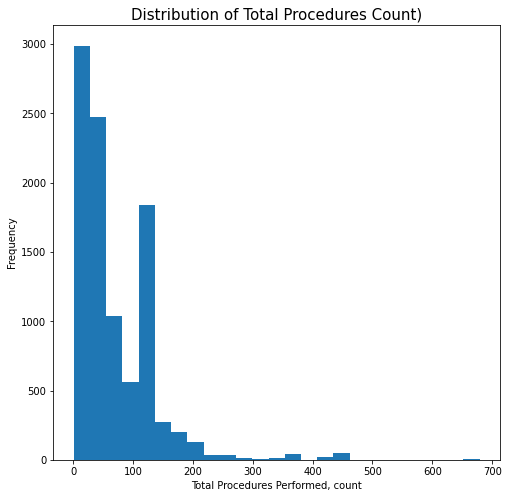

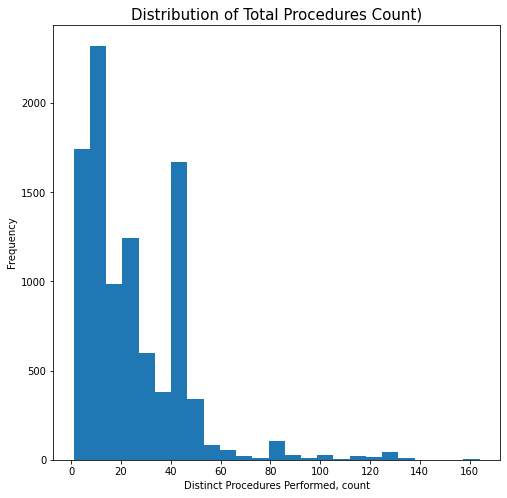

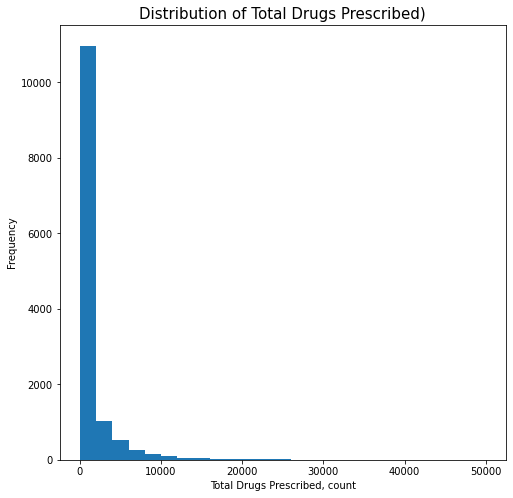

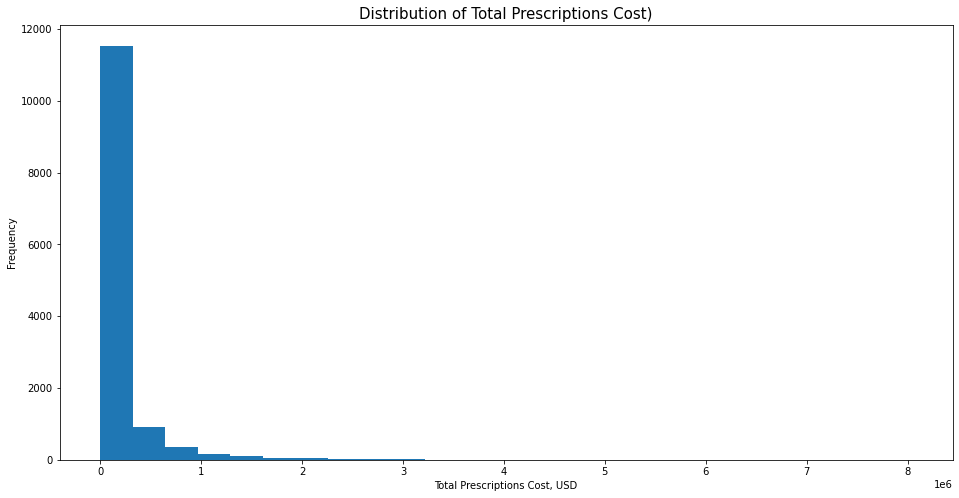

In [113]:
plt.figure(figsize=(8,8))
plt.xlabel('Total Procedures Performed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count)',fontsize=15)
plt.hist(data['total_procedures'], bins=25)
plt.show()

plt.figure(figsize=(8,8))
plt.xlabel('Distinct Procedures Performed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count)',fontsize=15)
plt.hist(data['distinct_procedures'], bins=25)
plt.show()


plt.figure(figsize=(8,8))
plt.xlabel('Total Drugs Prescribed, count',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Drugs Prescribed)',fontsize=15)
plt.hist(data['total_claim_count'], bins=25)
plt.show()

plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost)',fontsize=15)
plt.hist(data['total_drug_cost'], bins=25)
plt.show()

It appears that all the continious variables repeat the same distribution pattern as 'Money_Generated'. We'll log-transform them in the next step. In the meantime, the chart indicates the presence of extreme outliers in the 'total_drug_cost' variable that might tremendously distort its measures of central tendency

In [115]:
print(data['total_drug_cost'].min())
print(data['total_drug_cost'].max())
print(data['total_drug_cost'].mean())
print(data['total_drug_cost'].std())
data['total_drug_cost'].quantile(q=0.95)

17.63
8042473.68
142181.62685854768
360671.04838664475


712087.7774999995

Indeed, the max total cost of all drugs prescribed is 8M USD, whereas 95% of the sample prescribed drugs that cost less than 800K USD in total. Let's remove these outliers:

In [116]:
data = data.loc[(data['total_drug_cost'] <=712088)]
data.shape

(12559, 25)

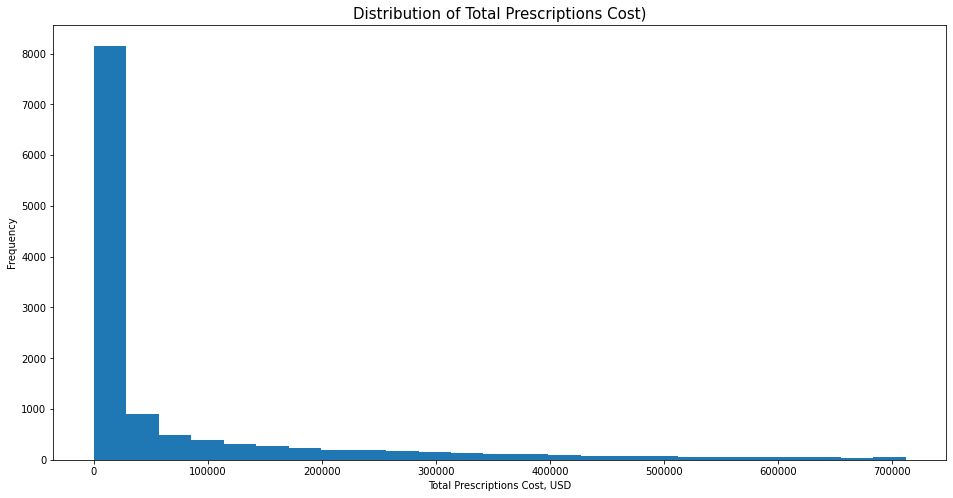

17.63
712053.36
77308.99842742263
142433.19770742767


In [117]:
plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost)',fontsize=15)
plt.hist(data['total_drug_cost'], bins=25)
plt.show()
print(data['total_drug_cost'].min())
print(data['total_drug_cost'].max())
print(data['total_drug_cost'].mean())
print(data['total_drug_cost'].std())

Indeed, the removal of only 5% of the sample lowered the mean by 50%! The distribution is still very skewed, so let's proceed with the log transformation of the variables. 

In [118]:
data['total_procedures_log'] = np.log10(data['total_procedures'])
data['distinct_procedures_log'] = np.log10(data['distinct_procedures'])
data['total_claim_count_log'] = np.log10(data['total_claim_count'])
data['total_drug_cost_log'] = np.log10(data['total_drug_cost'])

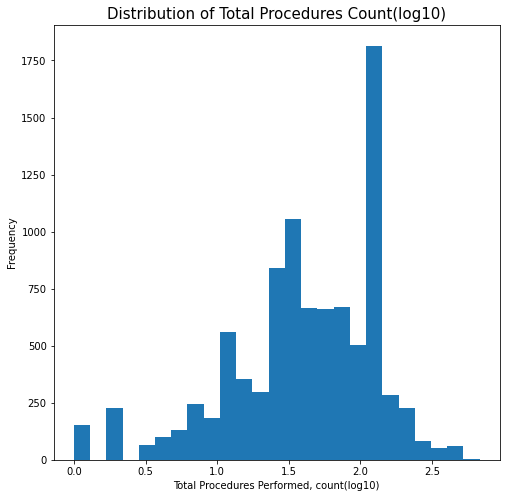

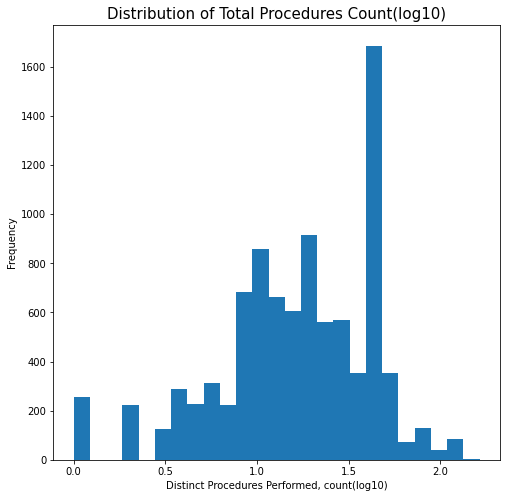

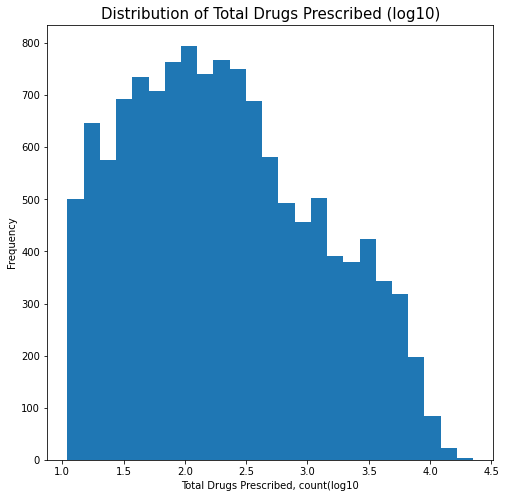

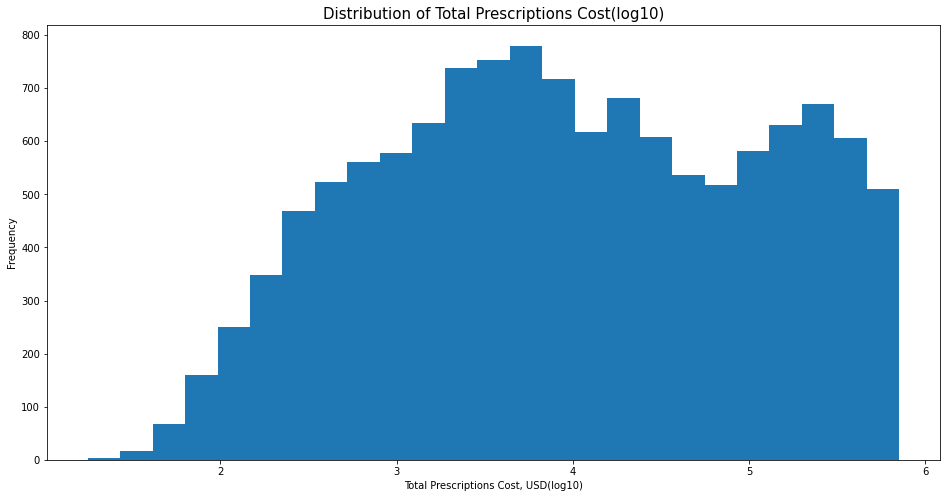

In [119]:
plt.figure(figsize=(8,8))
plt.xlabel('Total Procedures Performed, count(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count(log10)',fontsize=15)
plt.hist(data['total_procedures_log'], bins=25)
plt.show()

plt.figure(figsize=(8,8))
plt.xlabel('Distinct Procedures Performed, count(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Procedures Count(log10)',fontsize=15)
plt.hist(data['distinct_procedures_log'], bins=25)
plt.show()


plt.figure(figsize=(8,8))
plt.xlabel('Total Drugs Prescribed, count(log10',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Drugs Prescribed (log10)',fontsize=15)
plt.hist(data['total_claim_count_log'], bins=25)
plt.show()

plt.figure(figsize=(16,8))
plt.xlabel('Total Prescriptions Cost, USD(log10)',fontsize=10)
plt.ylabel('Frequency',fontsize=10)
plt.title('Distribution of Total Prescriptions Cost(log10)',fontsize=15)
plt.hist(data['total_drug_cost_log'], bins=25)
plt.show()

The new distributions look a lot better!

Let's explore categorical variables to see if they need any transformations.

In [128]:
print(data['state'].unique())

['NH' 'VT' 'MA' 'CT' 'FL' 'NY' 'NJ' nan 'PA' 'DE' 'MD' 'DC' 'VA' 'WV' 'NC'
 'GA' 'SC' 'WA' 'OH' 'IN' 'MO' 'IL' 'MI' 'OR' 'WI' 'KY' 'TN' 'AL' 'MN'
 'NM' 'AR' 'TX' 'CO' 'AZ' 'UT' 'CA' 'BC' 'AK' 'NV' 'KS' 'RI' 'MS' 'OK'
 'IA' 'HI' 'SD' 'NE' 'LA' 'ID' 'WY' 'MT' 'PR' 'ME' 'ON' 'ND' 'VIC']


state 'VIC' looks suspicious

In [129]:
print(data.loc[data['state']=='VIC'])

      money_generated  impressions_count       city state zipcode  \
8342         0.064455                  1  Parkville   VIC    3050   
8602         0.012689                  4  Parkville   VIC    3052   
8603         0.003155                  1  Parkville   VIC    3052   

     sole_proprietor                                   specialty  \
8342               N  Internal Medicine - Cardiovascular Disease   
8602               N                          Emergency Medicine   
8603               N                          Emergency Medicine   

      total_procedures  distinct_procedures derived_specialty_list  ...  \
8342               NaN                  NaN                  CD,IM  ...   
8602               NaN                  NaN                     EM  ...   
8603               NaN                  NaN                     EM  ...   

     hospital_longitude  hospital_size  hospital_system_membership  \
8342                NaN            NaN                         NaN   
8602     

Turns out that Parkville, VIC is located in Australia. We are interested in US recipients, so we'll drop these rows

In [130]:
data = data.drop([8342, 8602, 8603])

In [131]:
print(data['state'].unique())

['NH' 'VT' 'MA' 'CT' 'FL' 'NY' 'NJ' nan 'PA' 'DE' 'MD' 'DC' 'VA' 'WV' 'NC'
 'GA' 'SC' 'WA' 'OH' 'IN' 'MO' 'IL' 'MI' 'OR' 'WI' 'KY' 'TN' 'AL' 'MN'
 'NM' 'AR' 'TX' 'CO' 'AZ' 'UT' 'CA' 'BC' 'AK' 'NV' 'KS' 'RI' 'MS' 'OK'
 'IA' 'HI' 'SD' 'NE' 'LA' 'ID' 'WY' 'MT' 'PR' 'ME' 'ON' 'ND']


This looks better. Moving onto the next variable, 'sole_proprietor' which reflects whether the doctor owns the practice they work at.

In [132]:
print(data['sole_proprietor'].value_counts())

N    9795
Y    2648
X      73
Name: sole_proprietor, dtype: int64


We see value X which I suspect can indicate a checkbox checked. So let's recode these values into 'Y'

In [133]:
data['sole_proprietor'].replace({'X':'Y'}, inplace=True)
print(data['sole_proprietor'].value_counts())

N    9795
Y    2721
Name: sole_proprietor, dtype: int64


Let's move onto Specialty.

In [134]:
print(data['specialty'].value_counts())

Internal Medicine                                                 2088
Urology                                                            698
Internal Medicine - Cardiovascular Disease                         695
Student in an Organized Health Care Education/Training Program     588
Family Medicine                                                    529
                                                                  ... 
Nurse Practitioner - Women`s Health                                  1
Internal Medicine - Addiction Medicine                               1
Pediatrics - Adolescent Medicine                                     1
MS Genetic Counselor                                                 1
Physical Medicine and Rehabilitation - Brain Injury Medicine         1
Name: specialty, Length: 188, dtype: int64


188 distinct specialties sounds like too many for a meaningful analysis.The format of this variable is "Broad Specialty - Specialization". We'll get rid of specializations and group doctors by broader practice areas. On the other hand, 'Internal Medicine' seems to be too broad, let's see how many distinct specialties there are. 

In [136]:
internal_medicine = data[data.specialty.str.startswith('Internal')]
print(internal_medicine['specialty'].value_counts())


Internal Medicine                                            2088
Internal Medicine - Cardiovascular Disease                    695
Internal Medicine - Gastroenterology                          504
Internal Medicine - Geriatric Medicine                        438
Internal Medicine - Pulmonary Disease                         339
Internal Medicine - Hematology and Oncology                   324
Internal Medicine - Infectious Disease                        252
Internal Medicine - Interventional Cardiology                 201
Internal Medicine - Bariatric Medicine                        162
Internal Medicine - Critical Care Medicine                    157
Internal Medicine - Nephrology                                111
Internal Medicine - Diabetes and Metabolism Endocrinology     105
Internal Medicine - Medical Oncology                           94
Internal Medicine - Clinical Cardiac Electrophysiology         31
Internal Medicine - Rheumatology                               30
Internal M

Let's recode some of the frequent values into separate specialties:

In [137]:
data.replace({'specialty' : {'Internal Medicine - Cardiovascular Disease': 'Cardiology',
                             'Internal Medicine - Gastroenterology': 'Gastroenterology',
                             'Internal Medicine - Geriatric Medicine': 'Geriatric Medicine',
                             'Internal Medicine - Pulmonary Disease': 'Pulmonolgy',
                             'Internal Medicine - Hematology and Oncology': 'Hematology and Oncology',
                             'Internal Medicine - Infectious Disease': 'Infectious Disease',
                             'Internal Medicine - Interventional Cardiology': 'Cardiology',
                             'Internal Medicine - Bariatric Medicine': 'Bariatric Medicine',
                             'Internal Medicine - Critical Care Medicine': 'Emergency Medicine',
                             'Internal Medicine - Nephrology': 'Nephrology',
                             'Internal Medicine - Diabetes and Metabolism Endocrinology': 'Endocrinology',
                             'Internal Medicine - Medical Oncology': 'Hematology and Oncology',
                             'Internal Medicine - Clinical Cardiac Electrophysiology':'Cardiology',
                             'Internal Medicine - Rheumatology': 'Rheumatology',
                             'Internal Medicine - Sports Medicine':'Sports Medicine',
                             'Internal Medicine - Hematology':'Hematology and Oncology',
                             'Internal Medicine - Adult Congenital Heart Disease':'Cardiology'
                             
                             
                             
                             
                             
                             
                             
}}, inplace=True)

In [138]:
data['specialty'] = data['specialty'].str.split(' -',1).str[0]

In [139]:
specialty_list = data['specialty'].unique()
print(len(specialty_list))
print(data['specialty'].value_counts())

66
Internal Medicine                                                 2149
Cardiology                                                         928
Urology                                                            715
Emergency Medicine                                                 659
Student in an Organized Health Care Education/Training Program     588
                                                                  ... 
Chiropractor                                                         1
MS Genetic Counselor                                                 1
Audiologist                                                          1
Specialist/Technologist                                              1
Legal Medicine                                                       1
Name: specialty, Length: 66, dtype: int64


In [140]:
data['specialty'].unique()

array(['Cardiology', 'Physician Assistant', 'Internal Medicine',
       'Bariatric Medicine', 'Hematology and Oncology',
       'Psychiatry and Neurology', 'Dermatology', 'Emergency Medicine',
       'Pathology', 'Urology', 'Radiology', 'Gastroenterology',
       'Hospitalist', 'Endocrinology',
       'Student in an Organized Health Care Education/Training Program',
       'Nephrology', 'Pulmonolgy', 'Surgery', 'Anesthesiology',
       'Specialist', 'Registered Nurse',
       'Certified Registered Nurse Anesthetist', 'Rheumatology',
       'Obstetrics and Gynecology', 'Preventive Medicine',
       'Geriatric Medicine', 'General Acute Care Hospital', 'Optometrist',
       'Family Medicine', 'Colon and Rectal Surgery',
       'Nurse Practitioner', 'Infectious Disease', 'General Practice',
       'Prevention Professional', 'Pharmacist', 'Pediatrics',
       'Physical Therapist', 'Pharmacy Technician', 'Ophthalmology',
       'Allergy and Immunology', 'Physical Medicine and Rehabilitation'

Let's combine some of the values that are within the same treatment areas, e.g group all surgeons and nurses to reduce the count of categories

In [141]:
data.replace({'specialty' : { 'Certified Registered Nurse Anesthetist' :'Nurse/PA/Technician', 
                             'Clinical Nurse Specialist' : 'Nurse/PA/Technician', 'Physician Assistant' : 'Nurse/PA/Technician',
                          'Nurse Practitioner':'Nurse/PA/Technician', 'Registered Nurse': 'Nurse/PA/Technician',
                           'Specialist': 'Nurse/PA/Technician', 'Specialist/Technologist':'Nurse/PA/Technician',
                            'Colon and Rectal Surgery':'Surgery', 'Female Pelvic Medicine and Reconstructive Surgery':'Surgery',
                             'Neurological Surgery':'Surgery','Oral and Maxillofacial Surgery':'Surgery',
                             'Orthopaedic Surgery':'Surgery','Plastic Surgery':'Surgery',
                             'Thoracic Surgery (Cardiothoracic Vascular Surgery)':'Surgery','Transplant Surgery':'Surgery',
                             'Personal Emergency Response Attendant':'Emergency Medicine',
                             'MS Genetic Counselor':'Medical Genetics',
                             'Neuromusculoskeletal Medicine Sports Medicine':'Sports Medicine',
                             'Optometrist':'Ophthalmology', 
                             'Speech-Language Pathologist':'Pathology', 
                             'Pharmacy Technician':'Pharmacist',
                             'Physical Medicine and Rehabilitation':'Physical Therapist',
                             'Rehabilitation Practitioner':'Physical Therapist',
                             'Prevention Professional':'Preventive Medicine',
                             'Student in an Organized Health Care Education/Training Program': 'Student',
                             'Advanced Heart Failure & Transplant Cardiology': 'Cardiology'
}}, inplace=True)

In [142]:
specialty_list = data['specialty'].unique()
print(len(specialty_list))
print(data['specialty'].value_counts())

42
Internal Medicine              2149
Cardiology                      942
Urology                         715
Emergency Medicine              665
Nurse/PA/Technician             610
Student                         588
Family Medicine                 578
Pharmacist                      576
Psychiatry and Neurology        526
Gastroenterology                504
Geriatric Medicine              438
Hematology and Oncology         424
Obstetrics and Gynecology       411
Surgery                         378
Ophthalmology                   350
Pulmonolgy                      339
Radiology                       334
Anesthesiology                  285
Hospitalist                     284
Infectious Disease              252
Pediatrics                      206
Dermatology                     201
Bariatric Medicine              162
Pathology                       115
Nephrology                      111
Endocrinology                   105
Physical Therapist               67
General Practice         

This looks a lot cleaner! Let's move onto the next variable, publicationid, which indicates which NewsLetter the receipient receives

In [143]:
data['publicationid'].value_counts()

AMA       7310
ASHP       688
ACC        630
ASCO       610
CCF        515
AGA        419
ATS        360
ACEP       359
AUA        336
NAPNAP     294
AOA        270
APA        264
AAD        171
ENDO        91
ASN         76
ACPE        60
AMCP        40
SEMPA       23
MSSNY       17
ACRAD       12
ASCP        10
DIA          1
Name: publicationid, dtype: int64

Publicationid seems to be clean. Let's explore 'is_pii_enabled' which indicates whether the recipient allows sharing personal information with advertisers

In [144]:
data['is_pii_enabled'].value_counts()

b'\x00'    10093
b'\x01'     2463
Name: is_pii_enabled, dtype: int64

Wow, this one looks bad! Value of 0 in the original dataset meant that PII sharing was not allowed, whereas value of 1 meant it is OK to share the recipient's personal data with advertisers. Let's recode this variable

In [151]:
#data['is_pii_enabled'] = data['is_pii_enabled'].str.split('x',1).str[1]
#data['is_pii_enabled'] = data['is_pii_enabled'].str.split("'",1).str[0]
data.replace({'is_pii_enabled':{'00': 0, '01':1}}, inplace=True)
data['is_pii_enabled'].value_counts()

0    10093
1     2463
Name: is_pii_enabled, dtype: int64

Let's move onto 'hospital_system_membership'. We saw earlier that it was only coded for 'Yes', but not for 'N'. Let's add this value and recode the variable into 1 for 'Yes' and 0 for 'No'

In [152]:
data['hospital_system_membership'].value_counts()

Y    5738
Name: hospital_system_membership, dtype: int64

In [159]:
data['hospital_system_membership'] = data['hospital_system_membership'].astype(object)
data.replace({'hospital_system_membership':{'Y':1}}, inplace=True)
data['hospital_system_membership'].fillna(0, inplace=True)
data['hospital_system_membership'].value_counts()

0.0    6818
1.0    5738
Name: hospital_system_membership, dtype: int64

Moving on to the next variable, the state where the hospital in which the doctor works is located.

In [161]:
data['hospital_state'].value_counts()

CO             1052
CA              901
PA              476
FL              464
MI              460
NH              362
AZ              340
IL              327
NY              324
TX              319
IN              289
OH              254
NC              226
GA              179
NJ              172
MA              170
VA              159
MD              132
SC              125
TN              122
WA              119
MN              118
MO              115
AK              102
OK               95
WI               93
UT               88
AL               74
KY               72
Puerto Rico      68
OR               62
CT               56
IA               50
ME               47
LA               43
WV               25
NM               22
KS               21
HI               19
DC               19
AR               18
RI               16
SD               16
NE               15
WY               14
DE               14
MS               12
NV                7
VT                7
ND                5


Nothing looks particularly suspicious here, so we can examine the next variable, the size of the hospital where each doctor works.

In [162]:
data['hospital_size'].value_counts()

Medium    3895
Large     3198
Small     1197
Name: hospital_size, dtype: int64

Hospital size looks OK. Let's move on to the last variable, 'derived_specialty_list'. This gives us additional information about each doctor's specialty. More specifically treatment areas in which doctors works if the specialty is multidisciplinary. The each value in a column represents a set of specialty codes. My assumption is that the more disciplines there are in the set, the more often the doctor will be targeted by different advertisers. Out task here is to transform this variable so that we get the counts of items in each set instead of specific codes.

In [165]:
data['derived_specialty_list'].value_counts()

IM,IMG,MPD,U                1215
IM,MPD                       735
EM                           295
GE,IM,MPD                    285
NURSE,NURSE PRACTITIONER     264
                            ... 
PLM,PMD                        1
MPD,IM                         1
N,RESIDENT                     1
PTH,RESIDENT,STUDENT           1
HPM,PLM                        1
Name: derived_specialty_list, Length: 676, dtype: int64

In [ ]:
We'll count subspecialties in each set by counting commas in that set and then adding 1 to the number of commas:

In [168]:
data['comma_count'] = data['derived_specialty_list'].str.count(',')
print(data['comma_count'])
data['sub_specialty_count'] = data['comma_count'] +1
print (data['sub_specialty_count'])
data['sub_specialty_count'].value_counts()

0        0.0
1        0.0
2        1.0
3        1.0
4        1.0
        ... 
12554    1.0
12555    0.0
12556    1.0
12557    0.0
12558    0.0
Name: comma_count, Length: 12556, dtype: float64
0        1.0
1        1.0
2        2.0
3        2.0
4        2.0
        ... 
12554    2.0
12555    1.0
12556    2.0
12557    1.0
12558    1.0
Name: sub_specialty_count, Length: 12556, dtype: float64


2.0     3003
4.0     2796
3.0     2385
1.0     2294
5.0      595
6.0      421
8.0      155
7.0       57
9.0        9
11.0       7
10.0       3
Name: sub_specialty_count, dtype: int64

In [170]:
data.drop(['comma_count'], axis=1,inplace=True)

We've dropped the column we no longer need. Let's save the cleaned dataset.

In [171]:
data.to_csv('C:/Users/emich/Google Drive/Data science/Capstone 3/Data/Data_Cleaned.csv')